# **Car price prediction**

In [153]:
# STEP 0: import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score


#apis
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
#modules
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge

# kfold
from sklearn.model_selection import KFold, StratifiedKFold

#normal lib
from statistics import mean
import joblib
import seaborn as sns

# **STEP 1. LOOK AT THE BIG PICTURE DEON**
# tell briefly about car prices and what features have been used

In [115]:
#STEP 2: GET THE DATA 
raw_data = pd.read_csv(r'car_price_prediction.csv')

In [116]:
# STEP 3: EDA 
# 3.1. briefly analyse the dataset with info, head and describe()
print("Dataset info:")
print(raw_data.info())

print("Data briefing: ")
print(raw_data.head())

print("Data describe: ")
print(raw_data.describe())

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Price             19237 non-null  int64  
 2   Levy              19237 non-null  object 
 3   Manufacturer      19237 non-null  object 
 4   Model             19237 non-null  object 
 5   Prod. year        19237 non-null  int64  
 6   Category          19237 non-null  object 
 7   Leather interior  19237 non-null  object 
 8   Fuel type         19237 non-null  object 
 9   Engine volume     19237 non-null  object 
 10  Mileage           19237 non-null  object 
 11  Cylinders         19237 non-null  float64
 12  Gear box type     19237 non-null  object 
 13  Drive wheels      19237 non-null  object 
 14  Doors             19237 non-null  object 
 15  Wheel             19237 non-null  object 
 16  Color             19237 no

In [117]:
# 3.1.1. Missing values:
print("Missing values: ")
print(raw_data.isna().sum())

Missing values: 
ID                  0
Price               0
Levy                0
Manufacturer        0
Model               0
Prod. year          0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Doors               0
Wheel               0
Color               0
Airbags             0
dtype: int64


In [118]:
#cleaning the mileague
raw_data['Mileage'] = raw_data['Mileage'].str.extract('(\d+)').astype(int)

# extracting the enginer volume
raw_data['Turbo'] = raw_data['Engine volume'].apply(lambda x: 1 if 'Turbo' in x else 0)
raw_data['Engine volume'] = raw_data['Engine volume'].str.extract(r'(\d+\.\d+|\d+)').astype(float)

# fix levy
raw_data['Levy'] = raw_data['Levy'].replace('-', '0').astype(int)

#drop the ID column
raw_data = raw_data.drop(columns = "ID")
print(raw_data.describe())

              Price          Levy    Prod. year  Engine volume       Mileage  \
count  1.923700e+04  19237.000000  19237.000000   19237.000000  1.923700e+04   
mean   1.855593e+04    632.528669   2010.912824       2.307990  1.532236e+06   
std    1.905813e+05    567.721688      5.668673       0.877805  4.840387e+07   
min    1.000000e+00      0.000000   1939.000000       0.000000  0.000000e+00   
25%    5.331000e+03      0.000000   2009.000000       1.800000  7.013900e+04   
50%    1.317200e+04    642.000000   2012.000000       2.000000  1.260000e+05   
75%    2.207500e+04    917.000000   2015.000000       2.500000  1.888880e+05   
max    2.630750e+07  11714.000000   2020.000000      20.000000  2.147484e+09   

          Cylinders       Airbags         Turbo  
count  19237.000000  19237.000000  19237.000000  
mean       4.582991      6.582627      0.100379  
std        1.199933      4.320168      0.300513  
min        1.000000      0.000000      0.000000  
25%        4.000000      4.00

In [119]:
cols=raw_data.columns
num_cols = raw_data._get_numeric_data()
num_cols= list(num_cols.columns)
cat_cols = list(set(cols) - set(num_cols))
cat_cols.sort()

print(f"Numerical features: {num_cols}")
print(f"Categorical features: {cat_cols}")
print(raw_data['Price'].value_counts()) 


Numerical features: ['Price', 'Levy', 'Prod. year', 'Engine volume', 'Mileage', 'Cylinders', 'Airbags', 'Turbo']
Categorical features: ['Category', 'Color', 'Doors', 'Drive wheels', 'Fuel type', 'Gear box type', 'Leather interior', 'Manufacturer', 'Model', 'Wheel']
Price
15681    280
470      274
14113    244
392      242
314      235
        ... 
42601      1
149        1
54349      1
54954      1
22075      1
Name: count, Length: 2315, dtype: int64


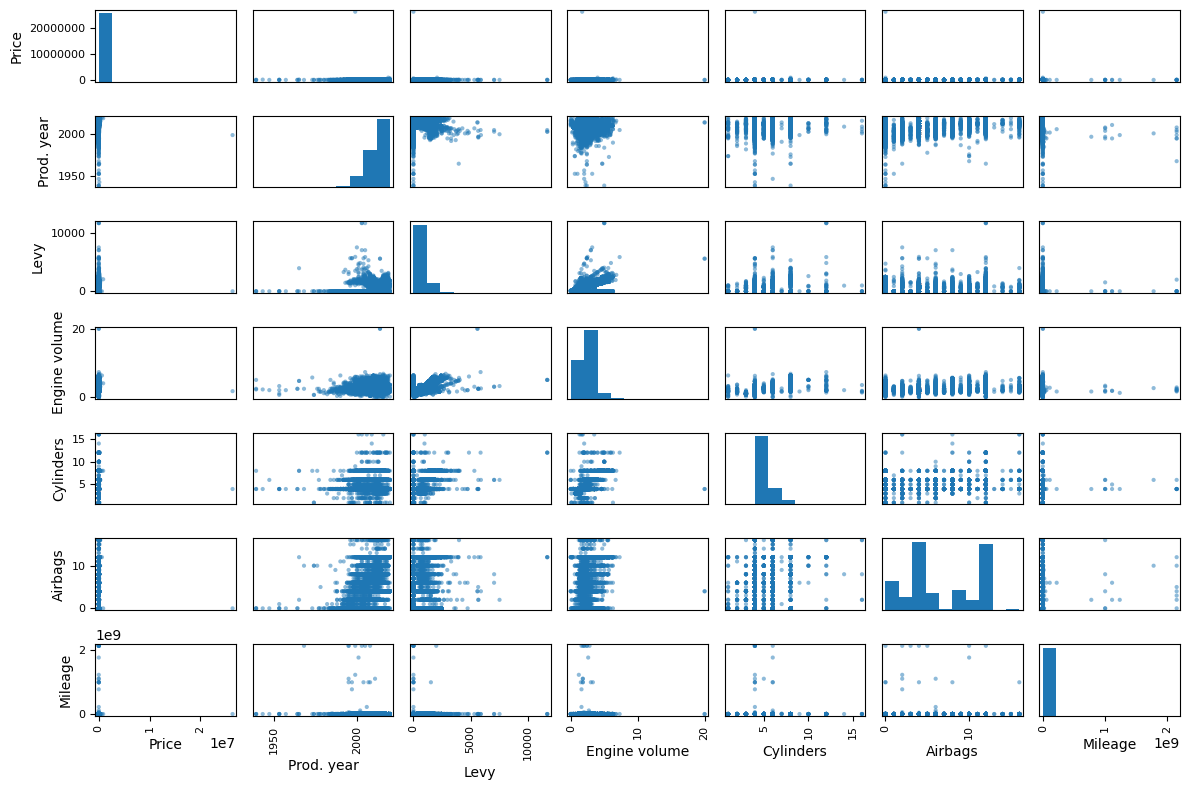

In [120]:
# 3.x. scatter matrix of numerical data
from pandas.plotting import scatter_matrix
def scatter(raw_data):
	attributes = ['Price', 'Prod. year', 'Levy', 'Engine volume', 'Cylinders', 'Airbags', 'Mileage'	]
	scatter_matrix(raw_data[attributes], figsize=(12, 8))
	plt.tight_layout()
	plt.show()
scatter(raw_data)

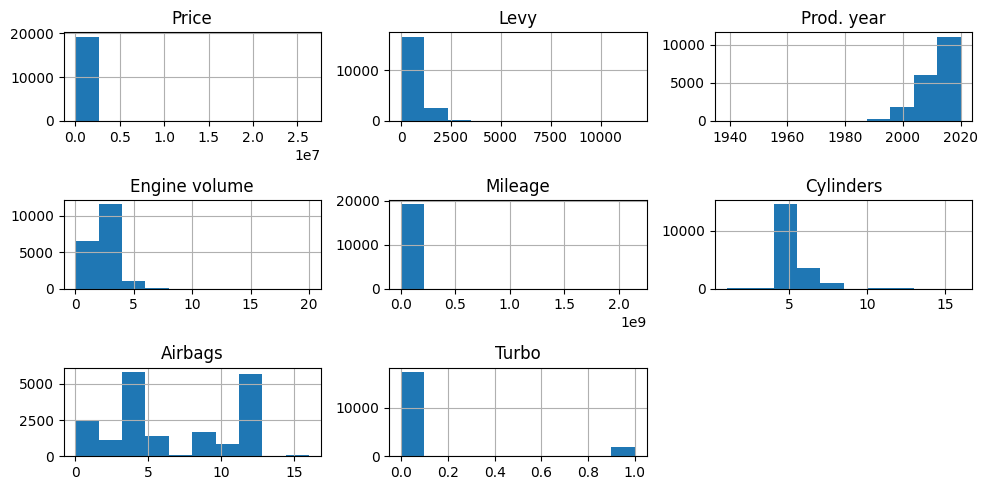

In [121]:
raw_data.hist(figsize=(10,5)) #bins: no. of intervals
plt.tight_layout()
# plt.rcParams['xtick.labelsize'] = 10
# plt.rcParams['ytick.labelsize'] = 10


In [122]:
corr_matrix = raw_data.corr(numeric_only=True)
print(corr_matrix)

                  Price      Levy  Prod. year  Engine volume   Mileage  \
Price          1.000000 -0.003701    0.012982       0.008753 -0.001758   
Levy          -0.003701  1.000000    0.364712       0.377438 -0.021034   
Prod. year     0.012982  0.364712    1.000000      -0.030906 -0.063501   
Engine volume  0.008753  0.377438   -0.030906       1.000000 -0.006289   
Mileage       -0.001758 -0.021034   -0.063501      -0.006289  1.000000   
Cylinders      0.007518  0.250950   -0.096797       0.778524 -0.001768   
Airbags       -0.012824  0.128032    0.236969       0.224441 -0.009201   
Turbo          0.017379 -0.166633   -0.076129      -0.017052 -0.001511   

               Cylinders   Airbags     Turbo  
Price           0.007518 -0.012824  0.017379  
Levy            0.250950  0.128032 -0.166633  
Prod. year     -0.096797  0.236969 -0.076129  
Engine volume   0.778524  0.224441 -0.017052  
Mileage        -0.001768 -0.009201 -0.001511  
Cylinders       1.000000  0.176868  0.036798  
Airb

                  Price      Levy  Prod. year  Engine volume   Mileage  \
Price          1.000000 -0.003701    0.012982       0.008753 -0.001758   
Levy          -0.003701  1.000000    0.364712       0.377438 -0.021034   
Prod. year     0.012982  0.364712    1.000000      -0.030906 -0.063501   
Engine volume  0.008753  0.377438   -0.030906       1.000000 -0.006289   
Mileage       -0.001758 -0.021034   -0.063501      -0.006289  1.000000   
Cylinders      0.007518  0.250950   -0.096797       0.778524 -0.001768   
Airbags       -0.012824  0.128032    0.236969       0.224441 -0.009201   
Turbo          0.017379 -0.166633   -0.076129      -0.017052 -0.001511   

               Cylinders   Airbags     Turbo  
Price           0.007518 -0.012824  0.017379  
Levy            0.250950  0.128032 -0.166633  
Prod. year     -0.096797  0.236969 -0.076129  
Engine volume   0.778524  0.224441 -0.017052  
Mileage        -0.001768 -0.009201 -0.001511  
Cylinders       1.000000  0.176868  0.036798  
Airb

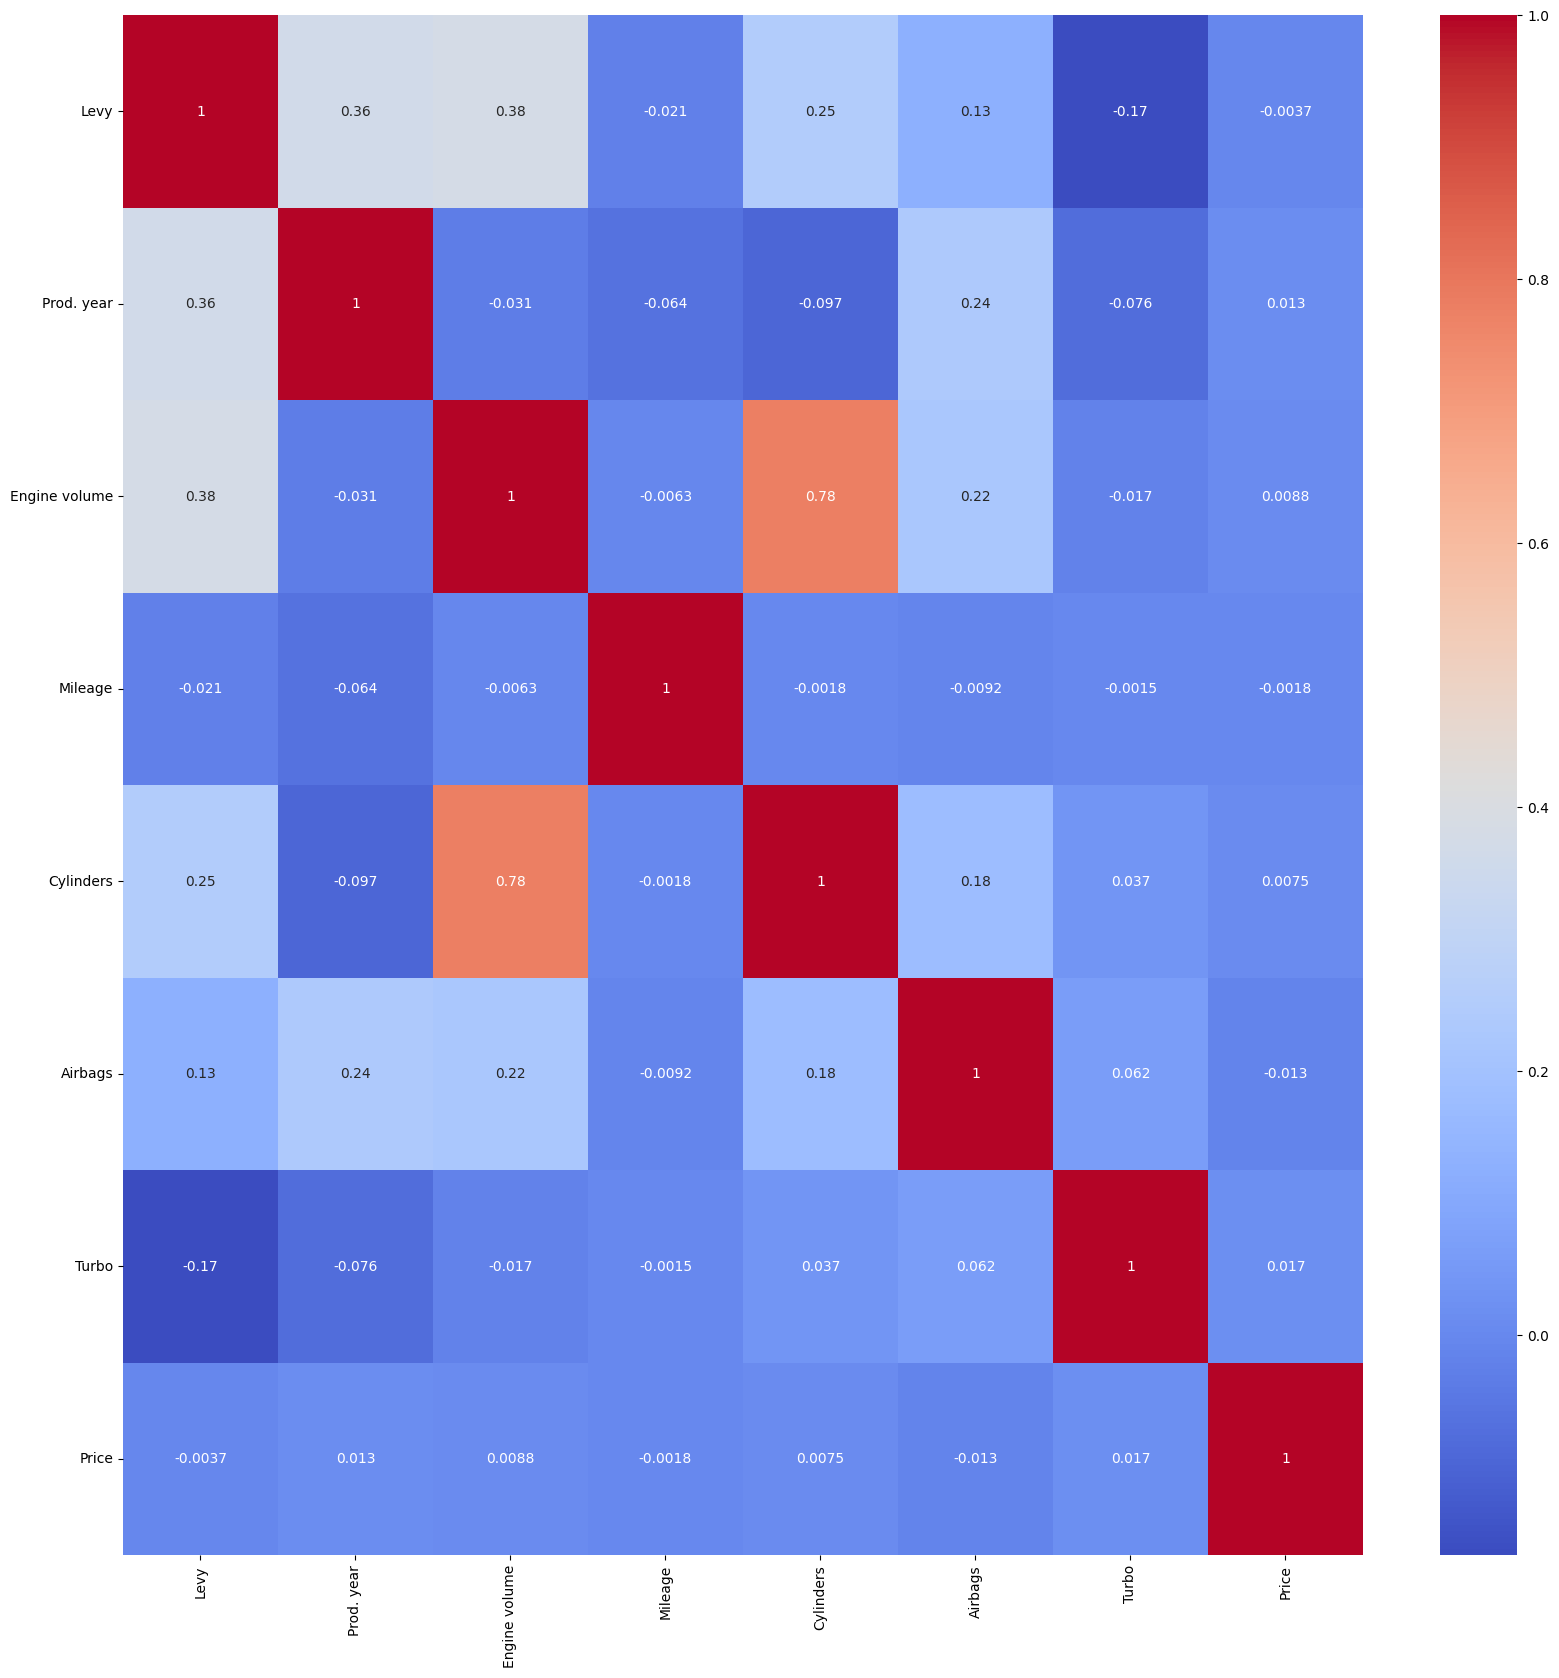

In [123]:
# 3.4 Correlation matrix
corr_matrix = raw_data.corr(numeric_only=True)
print(corr_matrix) # print correlation matrix
print('\n',corr_matrix["Price"].sort_values(ascending=False)) # print correlation b/w a feature and other features


columns = list(corr_matrix.columns)
columns.remove('Price')
columns.append('Price')
corr_matrix = corr_matrix. loc[columns, columns]

# Create a heatmap from the correlation matrix
plt. figure(figsize=(20, 20))
sns. heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.xticks(rotation=90, fontsize=10)
# Rotate y-axis labels
plt.yticks(rotation=0, fontsize=10)
plt.show()

In [124]:
# Pair plot
# sns.pairplot(raw_data)
# plt.show()

In [125]:
# # 3.x Try combining features
# raw_data["AREA PER ROOM"] = raw_data["AREA IN M2"] / raw_data["NUMBER OF BEDROOMS"] 
# corr_matrix = raw_data.corr(numeric_only=True)
# print(corr_matrix["PRICE IN MILLION VND"].sort_values(ascending=False)) # print correlation b/w a feature and other features
# raw_data.drop(columns = ["AREA PER ROOM", "TOTAL NUMBER OF ROOMS"], inplace=True) # remove experiment columns

# EDA on categorical features

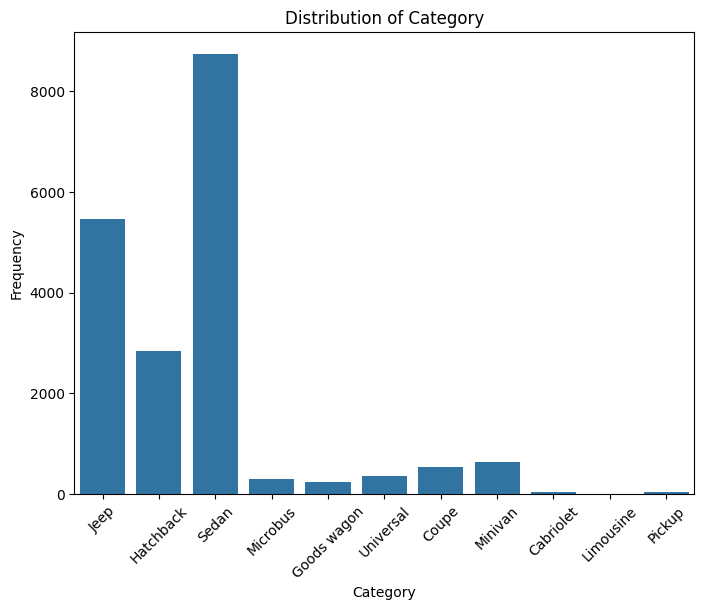

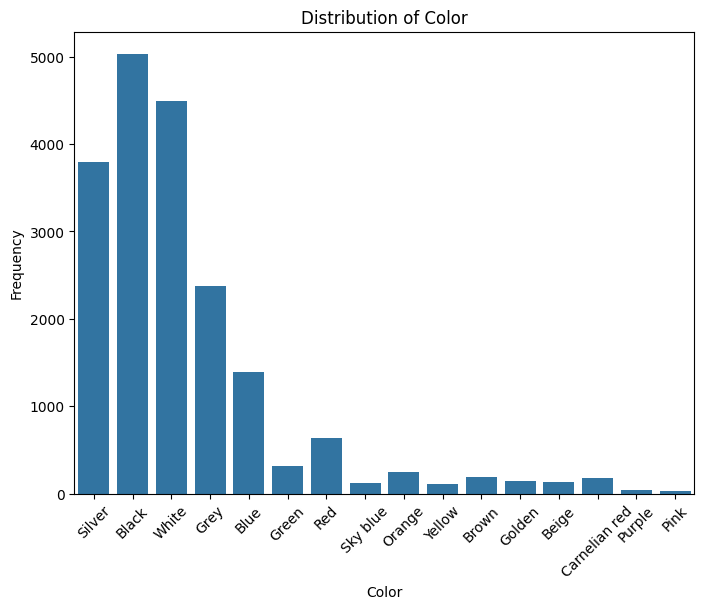

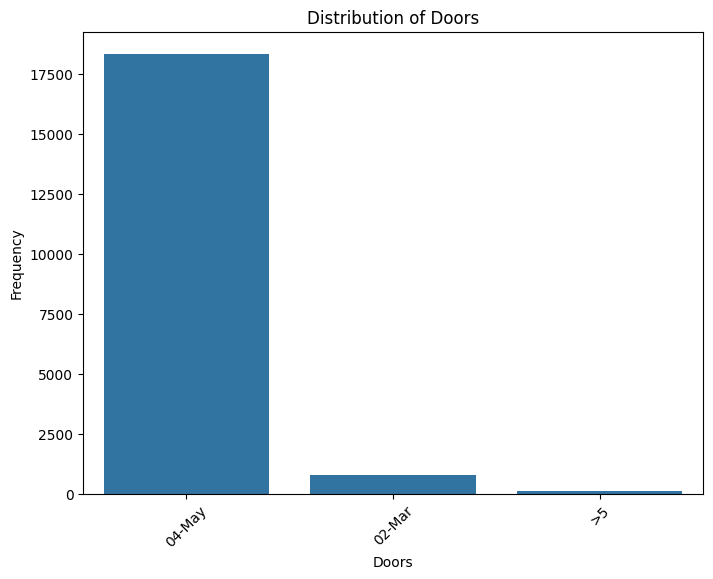

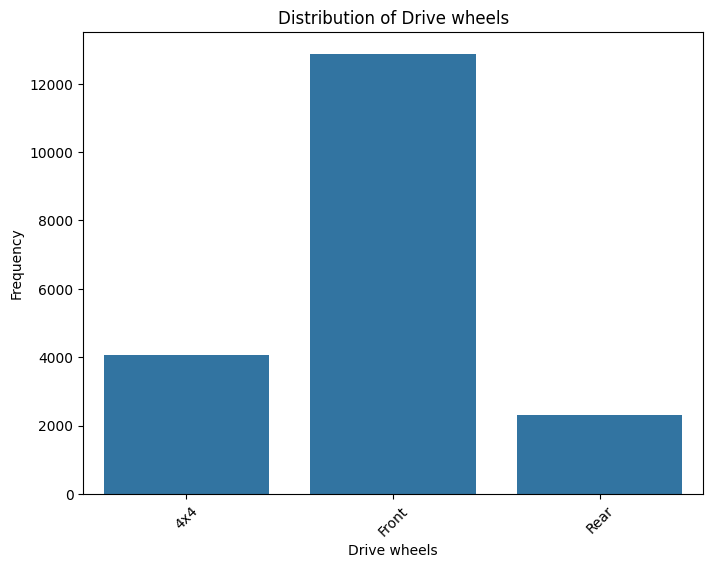

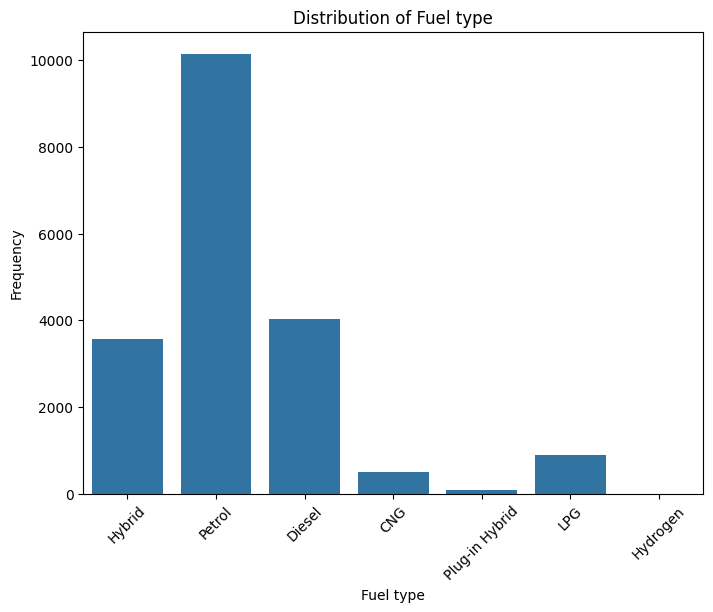

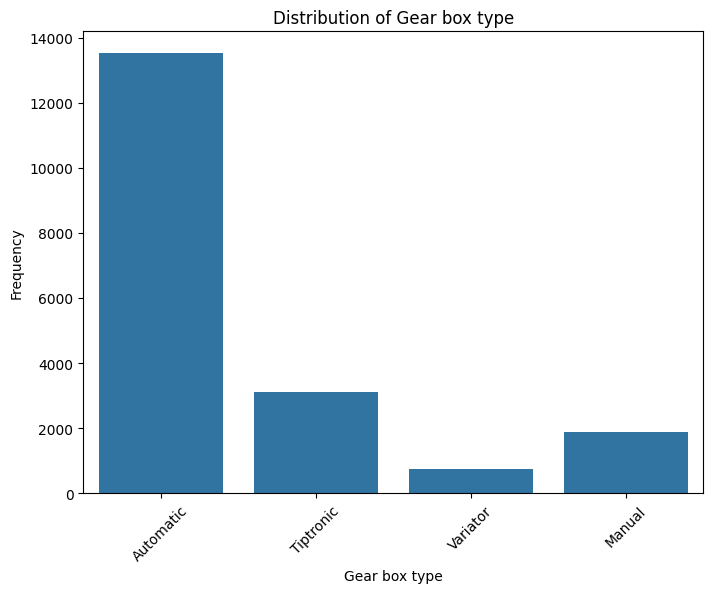

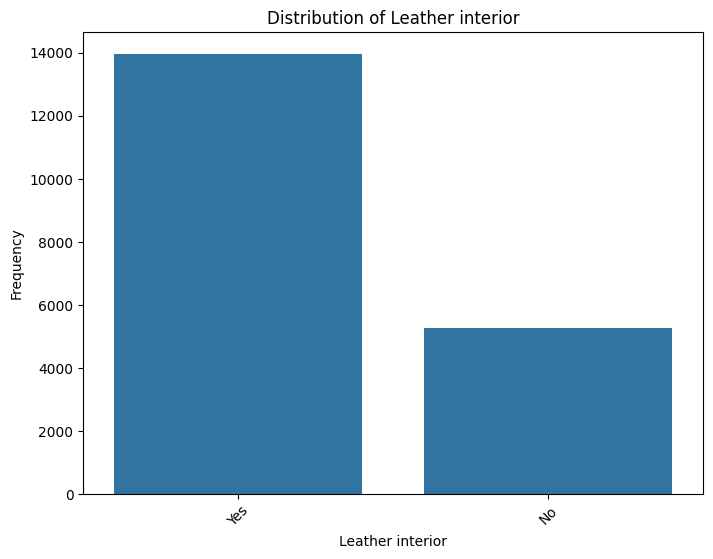

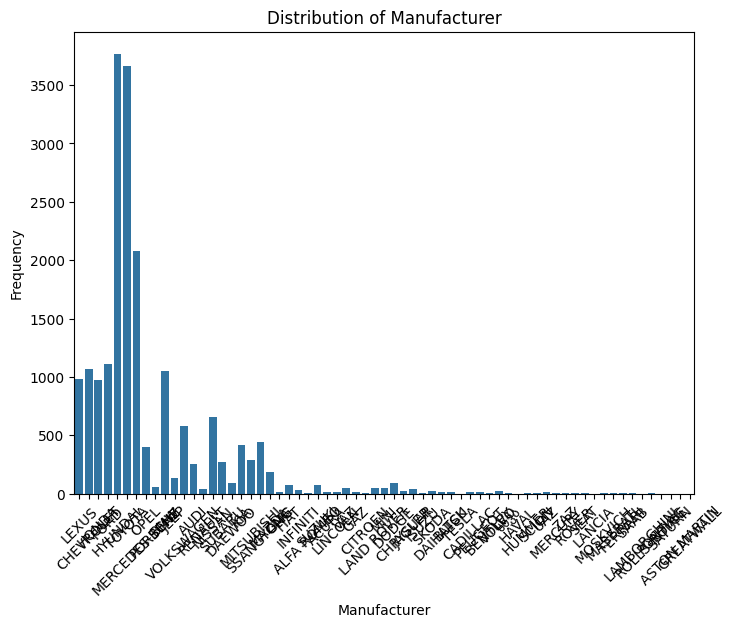

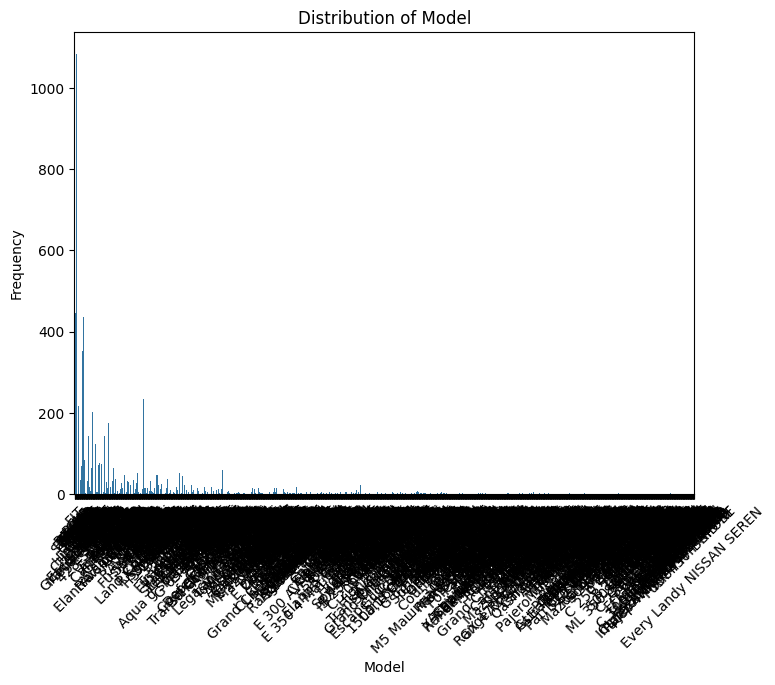

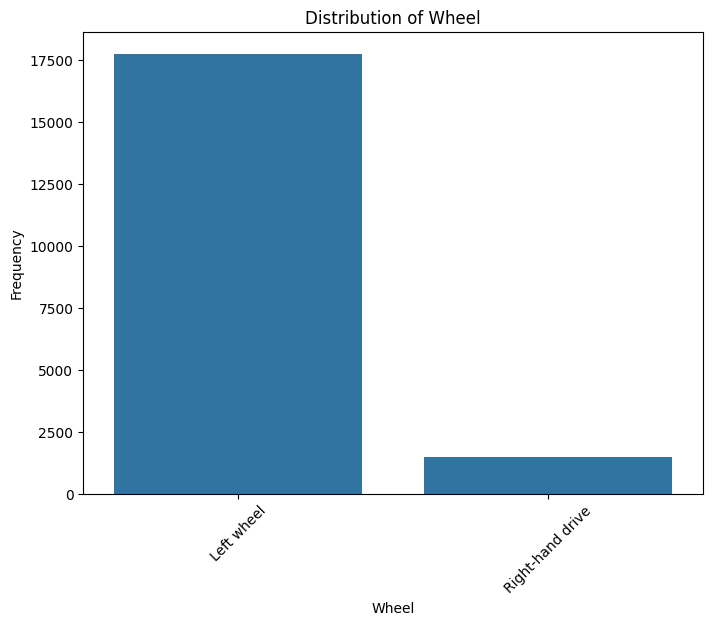

In [126]:
for feature in cat_cols:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=feature, data=raw_data)
    plt.xlabel(feature.capitalize())
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {feature.capitalize()}')
    plt.xticks(rotation=45)
    plt.show()
# print(cat_cols)

# STEP 4. PREPARE THE DATA 


In [127]:
# 4.1 Remove unused features
#print(raw_data)

In [128]:
# Check normality summary
def normality_sum(df):
    num_col = df.select_dtypes(include=[np.number]).columns

    result = []
    for col in num_col:
        skewness = df[col].skew()
        kurtosis = df[col].kurtosis()
        result.append({
            'Variable' : col,
            'Skewness' : skewness,
            'Kurtosis' : kurtosis,
            'Mean' : df[col].mean(),
            'Median' : df[col].median(),
            'Std Dev' : df[col].std(),
            'Potential Normal' : abs(skewness) <= 1 and abs(kurtosis) <= 3
        })

    return pd.DataFrame(result)

normality_df = normality_sum(raw_data.drop(['Price'], axis =1))
print("Summary")
print(normality_df)

Summary
        Variable   Skewness     Kurtosis          Mean    Median  \
0           Levy   2.376222    29.213355  6.325287e+02     642.0   
1     Prod. year  -2.082261    11.329766  2.010913e+03    2012.0   
2  Engine volume   2.186242    19.222583  2.307990e+00       2.0   
3        Mileage  38.896821  1598.756423  1.532236e+06  126000.0   
4      Cylinders   2.091083     6.486085  4.582991e+00       4.0   
5        Airbags   0.082012    -1.334021  6.582627e+00       6.0   
6          Turbo   2.659864     5.075407  1.003795e-01       0.0   

        Std Dev  Potential Normal  
0  5.677217e+02             False  
1  5.668673e+00             False  
2  8.778045e-01             False  
3  4.840387e+07             False  
4  1.199933e+00             False  
5  4.320168e+00              True  
6  3.005131e-01             False  


In [129]:
import numpy as np

def remove_outliers_iqr(data, factor=1.5):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    iqr = Q3 - Q1
    lower_bound = Q1 - factor * iqr
    upper_bound = Q3 + factor * iqr
    return lower_bound, upper_bound

# Assuming raw_data is a DataFrame and num_cols is a list of numerical columns
data_no_outliers = raw_data.copy()

# Remove rows where 'price' is less than 500
data_no_outliers = data_no_outliers[data_no_outliers['Price'] >= 500]

attributes = num_cols

for attribute in attributes:
    low, high = remove_outliers_iqr(data_no_outliers[attribute], factor=1.5)
    
    # Filter out rows where the attribute is an outlier
    outliers = (data_no_outliers[attribute] < low) | (data_no_outliers[attribute] > high)
    
    # Drop the outlier rows
    data_no_outliers = data_no_outliers[~outliers]

data_no_outliers.info()



<class 'pandas.core.frame.DataFrame'>
Index: 10047 entries, 2 to 19235
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             10047 non-null  int64  
 1   Levy              10047 non-null  int64  
 2   Manufacturer      10047 non-null  object 
 3   Model             10047 non-null  object 
 4   Prod. year        10047 non-null  int64  
 5   Category          10047 non-null  object 
 6   Leather interior  10047 non-null  object 
 7   Fuel type         10047 non-null  object 
 8   Engine volume     10047 non-null  float64
 9   Mileage           10047 non-null  int64  
 10  Cylinders         10047 non-null  float64
 11  Gear box type     10047 non-null  object 
 12  Drive wheels      10047 non-null  object 
 13  Doors             10047 non-null  object 
 14  Wheel             10047 non-null  object 
 15  Color             10047 non-null  object 
 16  Airbags           10047 non-null  int64  
 17

/Users/vantai/Library/Python/3.9/lib/python/site-packages/pandas/plotting/_matplotlib/misc.py:100: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/Users/vantai/Library/Python/3.9/lib/python/site-packages/pandas/plotting/_matplotlib/misc.py:101: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/Users/vantai/Library/Python/3.9/lib/python/site-packages/pandas/plotting/_matplotlib/misc.py:91: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[i])


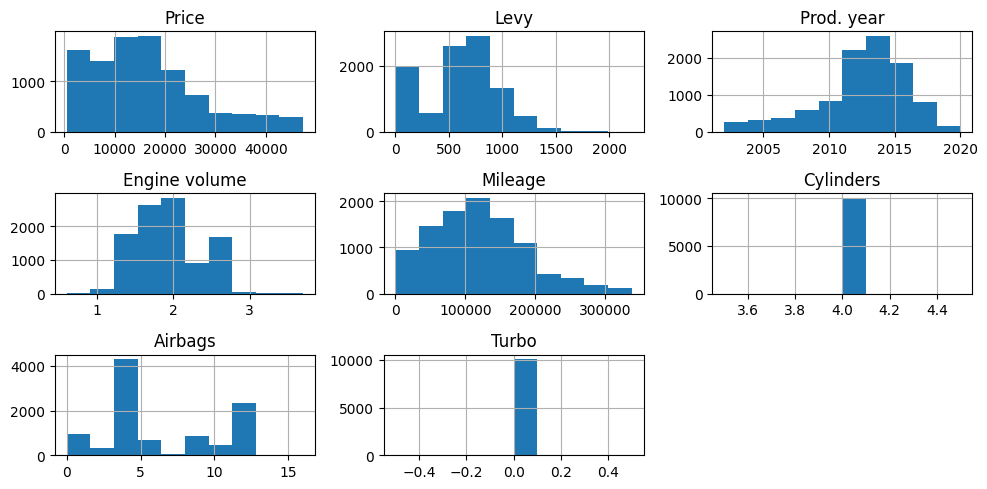

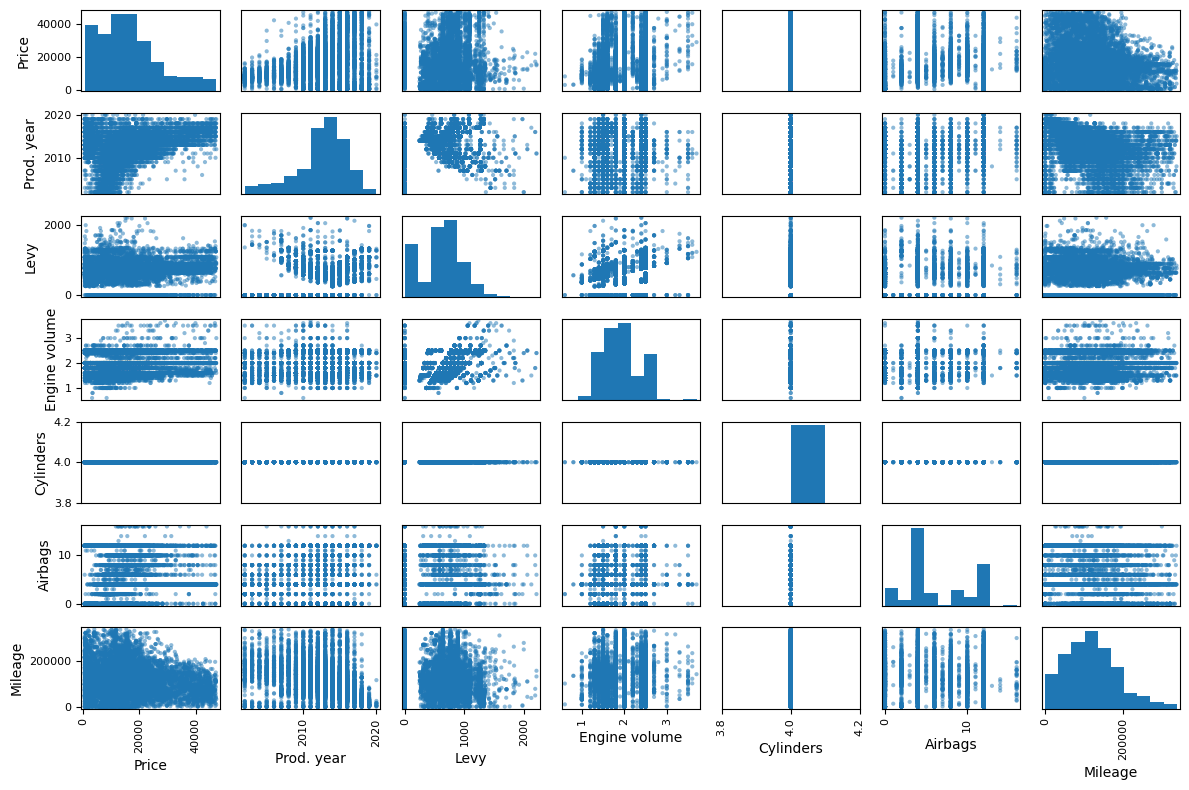

In [130]:
data_no_outliers.hist(figsize=(10,5)) #bins: no. of intervals
plt.tight_layout()

from pandas.plotting import scatter_matrix
def scatter(raw_data):
	attributes = ['Price', 'Prod. year', 'Levy', 'Engine volume', 'Cylinders', 'Airbags', 'Mileage'	]
	scatter_matrix(data_no_outliers[attributes], figsize=(12, 8))
	plt.tight_layout()
	plt.show()
scatter(data_no_outliers)

                  Price      Levy  Prod. year  Engine volume   Mileage  \
Price          1.000000  0.106311    0.329871       0.153631 -0.190731   
Levy           0.106311  1.000000    0.387184       0.304267 -0.146119   
Prod. year     0.329871  0.387184    1.000000       0.131086 -0.310447   
Engine volume  0.153631  0.304267    0.131086       1.000000  0.037659   
Mileage       -0.190731 -0.146119   -0.310447       0.037659  1.000000   
Cylinders           NaN       NaN         NaN            NaN       NaN   
Airbags       -0.170424  0.028742    0.189582       0.213246 -0.078005   
Turbo               NaN       NaN         NaN            NaN       NaN   

               Cylinders   Airbags  Turbo  
Price                NaN -0.170424    NaN  
Levy                 NaN  0.028742    NaN  
Prod. year           NaN  0.189582    NaN  
Engine volume        NaN  0.213246    NaN  
Mileage              NaN -0.078005    NaN  
Cylinders            NaN       NaN    NaN  
Airbags              NaN 

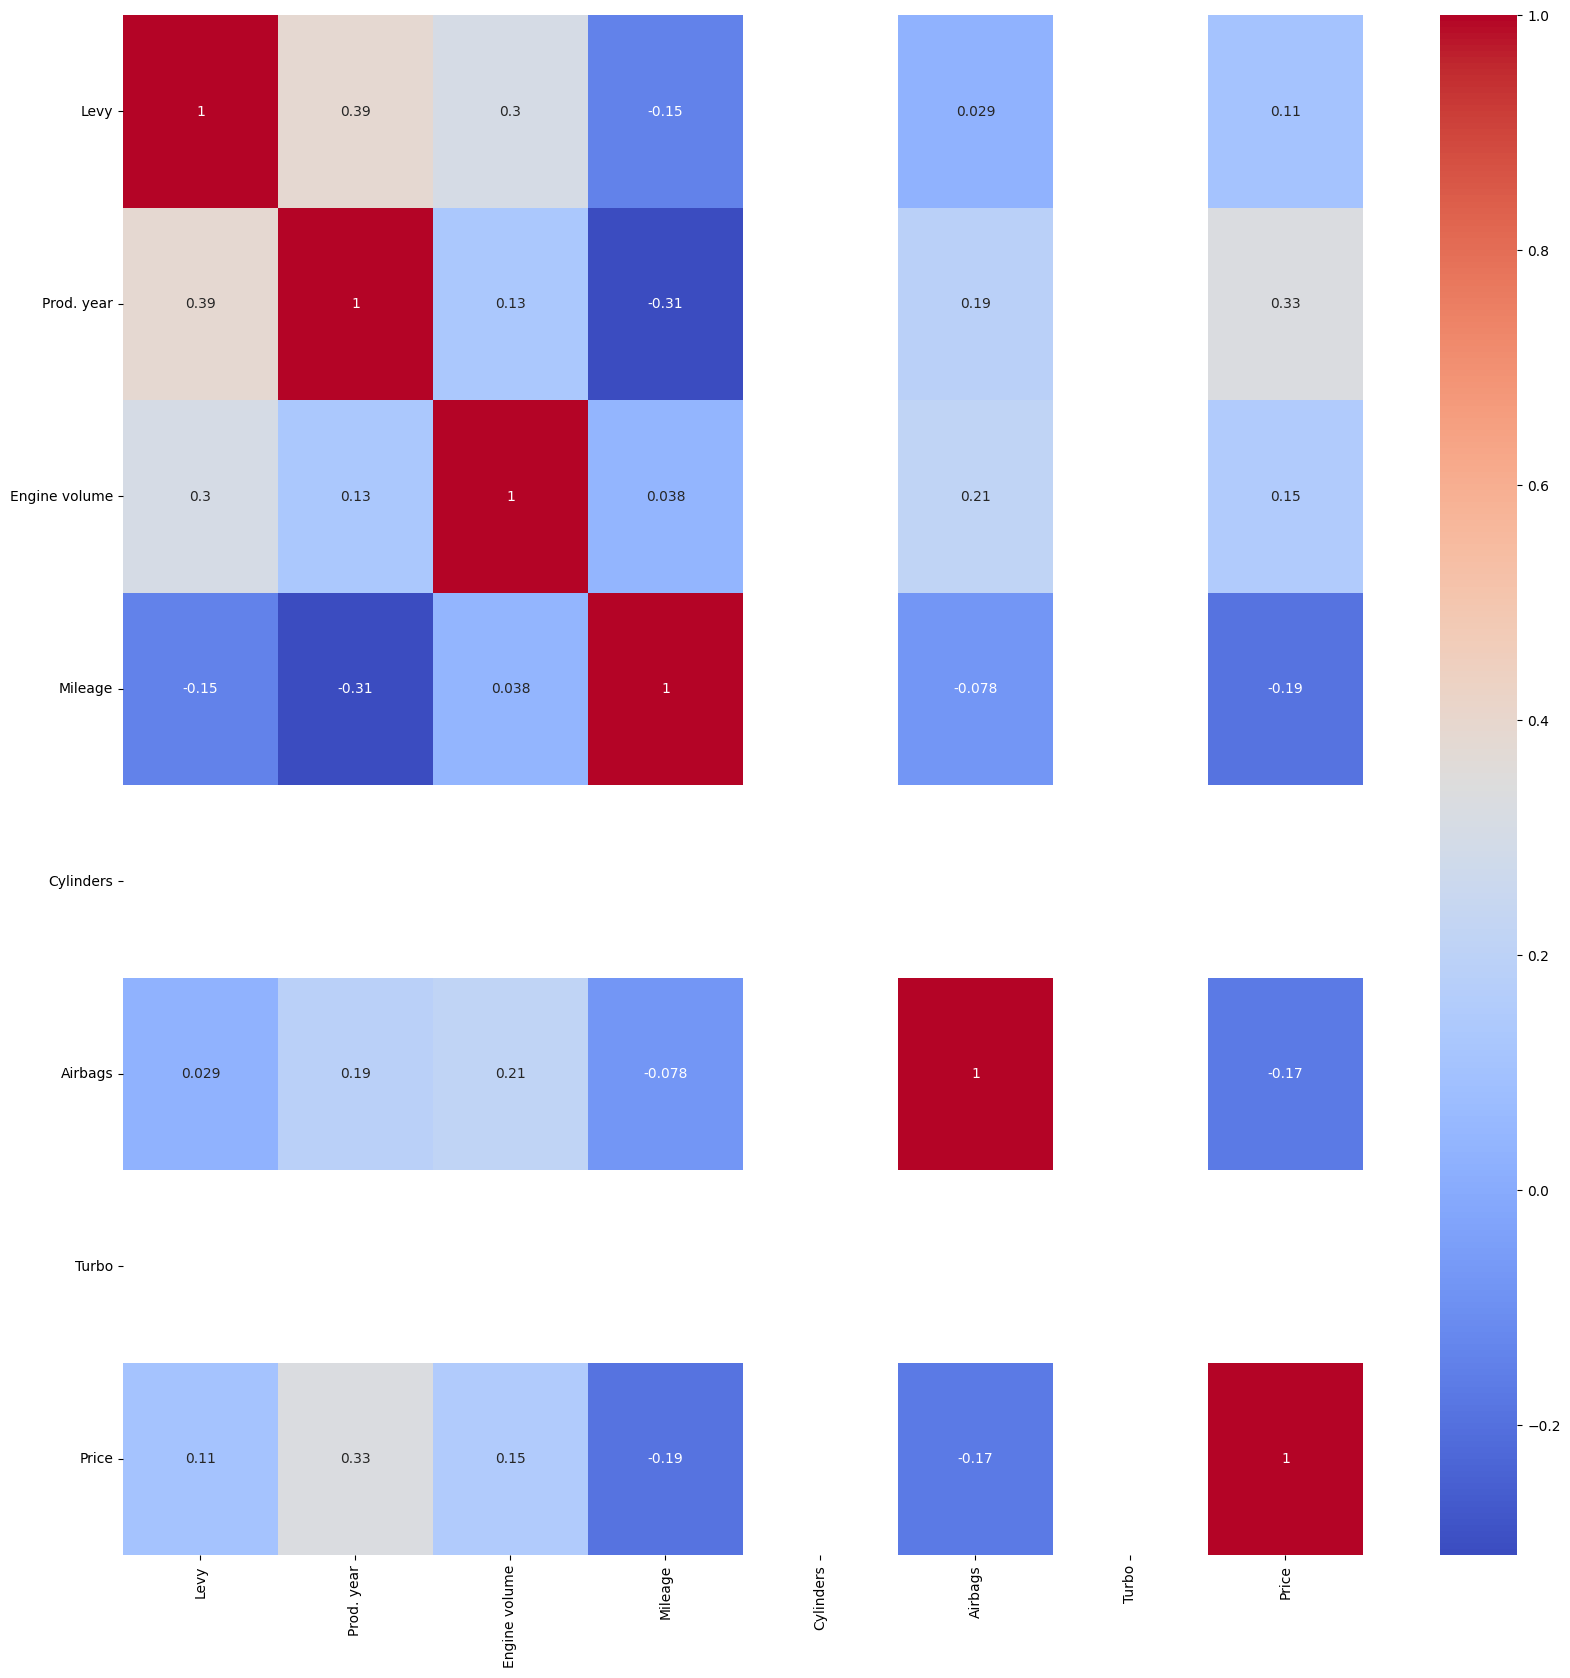

In [131]:
# 3.4 Correlation matrix
corr_matrix = data_no_outliers.corr(numeric_only=True)
print(corr_matrix) # print correlation matrix
print('\n',corr_matrix["Price"].sort_values(ascending=False)) # print correlation b/w a feature and other features

columns = list(corr_matrix.columns)

columns.remove('Price')
columns.append('Price')
corr_matrix = corr_matrix.loc[columns, columns]

# Create a heatmap from the correlation matrix
plt. figure(figsize=(20, 20))
sns. heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.xticks(rotation=90, fontsize=10)
# Rotate y-axis labels
plt.yticks(rotation=0, fontsize=10)
plt.show()

In [132]:
data_no_outliers.describe()

,Price,Levy,Prod. year,Engine volume,Mileage,Cylinders,Airbags,Turbo
count,10047.000000,10047.000000,10047.000000,10047.000000,10047.000000,10047.0,10047.000000,10047.0
mean,16414.773266,609.325570,2012.415547,1.939086,120096.360605,4.0,6.229223,0.0
std,11003.031107,374.353343,3.520143,0.398179,68216.169826,0.0,3.938396,0.0
min,500.000000,0.000000,2002.000000,0.600000,0.000000,4.0,0.000000,0.0
25%,8467.000000,419.000000,2011.000000,1.600000,70001.500000,4.0,4.000000,0.0
50%,15053.000000,642.000000,2013.000000,2.000000,115312.000000,4.0,4.000000,0.0
75%,21953.000000,831.000000,2015.000000,2.300000,160000.000000,4.0,10.000000,0.0
max,47408.000000,2209.000000,2020.000000,3.700000,338110.000000,4.0,16.000000,0.0


In [133]:
# 4.2 Split training - test set
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(data_no_outliers, test_size=0.2, random_state=42) # set random_state to get the same training set all the time, 
																					# otherwise, when repeating training many times, your model may see all the data
print('\n____________ Split training and test set ____________')     
print(len(train_set), "training +", len(test_set), "test examples")
print(test_set.head(4))


____________ Split training and test set ____________
8037 training + 2010 test examples
       Price  Levy Manufacturer     Model  Prod. year   Category  \
1380   20385     0       TOYOTA     Prius        2014  Hatchback   
2383   13485   878       TOYOTA     Prius        2009  Hatchback   
13722  24462     0       TOYOTA  Camry SE        2009      Sedan   
18886  17405   697      HYUNDAI   Elantra        2015      Sedan   

      Leather interior Fuel type  Engine volume  Mileage  Cylinders  \
1380               Yes    Hybrid            1.8    49000        4.0   
2383                No    Hybrid            1.8   257000        4.0   
13722              Yes    Petrol            2.5   210000        4.0   
18886               No    Petrol            1.8    96000        4.0   

      Gear box type Drive wheels   Doors       Wheel   Color  Airbags  Turbo  
1380      Automatic        Front  04-May  Left wheel  Silver       12      0  
2383      Automatic        Front  04-May  Left wheel  G

In [134]:
#%% 4.3 Separate labels from data, since we do not process label values
train_set_labels = train_set["Price"].copy()
train_set = train_set.drop(columns = "Price") 
test_set_labels = test_set["Price"].copy()
test_set = test_set.drop(columns = "Price") 


In [135]:
# 4.4 Define pipelines for processing data.
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names

    def fit(self, dataframe, labels=None):
        return self

    def transform(self, dataframe):
        return dataframe[self.feature_names].values


# categorical pipelines
cat_pipeline = Pipeline([
    ('selector', ColumnSelector(cat_cols)),
    ('imputer', SimpleImputer(missing_values="-", strategy="constant", fill_value="NO INFO",
     copy=True)),  # complete missing values. copy=False: imputation will be done in-place
    # convert categorical data into one-hot vectors
    ('cat_encoder', OneHotEncoder())
])

# # 4.4.3 Define MyFeatureAdder: a transformer for adding features "TOTAL NUMBER OF BEDROOMS",...
# class MyFeatureAdder(BaseEstimator, TransformerMixin):
#     def __init__(self, add_TOTAL_NO_OF_ROOMS = True): # MUST NO *args or **kargs
#         self.add_TOTAL_NO_OF_ROOMS = add_TOTAL_NO_OF_ROOMS
#     def fit(self, feature_values, labels = None):
#         return self  # nothing to do here
#     def transform(self, feature_values, labels = None):
#         if self.add_TOTAL_NO_OF_ROOMS:
#             NO_OF_ROOMS_id, NO_OF_TOILETS_id = 1, 2 # column indices in num_feat_names. can't use column names b/c the transformer SimpleImputer removed them
#             # NOTE: a transformer in a pipeline ALWAYS return dataframe.values (ie., NO header and row index)

#             TOTAL_NO_OF_ROOMS = feature_values[:, NO_OF_ROOMS_id] + feature_values[:, NO_OF_TOILETS_id]
#             feature_values = np.c_[feature_values, TOTAL_NO_OF_ROOMS] #concatenate np arrays
#         return feature_values


# 4.4.4 Pipeline for numerical features
num_cols.remove("Price")
print(num_cols)
num_pipeline = Pipeline([
    ('selector', ColumnSelector(num_cols)),
    # copy=False: imputation will be done in-place
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median", copy=True)),
    # ('attribs_adder', MyFeatureAdder(add_TOTAL_NO_OF_ROOMS = True)),
    # Scale features to zero mean and unit variance
    ('std_scaler', StandardScaler(with_mean=True, with_std=True, copy=True))
])

# 4.4.5 Combine features transformed by two above pipelines
full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline)])


# # 4.5 Run the pipeline to process training data
processed_train_set_val = full_pipeline.fit_transform(train_set)
print('\n____________ Processed feature values ____________')
print(processed_train_set_val[[0, 1, 2], :].toarray())
print(processed_train_set_val.shape)
print('We have %d numeric feature + 1 added features + 35 cols of onehotvector for categorical features.' % (len(num_cols)))
joblib.dump(full_pipeline, r'models/full_pipeline.pkl')

['Levy', 'Prod. year', 'Engine volume', 'Mileage', 'Cylinders', 'Airbags', 'Turbo']

____________ Processed feature values ____________
[[ 0.61803637 -0.67948553  0.1558945  ...  0.          1.
   0.        ]
 [-1.62056459 -1.52790995 -1.10383213 ...  0.          1.
   0.        ]
 [-1.62056459  0.45174703  1.41562114 ...  0.          1.
   0.        ]]
(8037, 686)
We have 7 numeric feature + 1 added features + 35 cols of onehotvector for categorical features.


['models/full_pipeline.pkl']

In [136]:
# # (optional) Add header to create dataframe. Just to see. We don't need header to run algorithms 
# onehot_cols = []
# for val_list in full_pipeline.transformer_list[1][1].named_steps['cat_encoder'].categories_: 
# 	onehot_cols = onehot_cols + val_list.tolist()
# columns_header = train_set.columns.tolist() + ["TOTAL NUMBER OF BEDROOMS"] + onehot_cols
# for name in cat_feat_names:
# 	columns_header.remove(name)
# processed_train_set = pd.DataFrame(processed_train_set_val.toarray(), columns = columns_header)
# print('\n____________ Processed dataframe ____________')
# print(processed_train_set.info())
# print(processed_train_set.head())


# Training Models

## Helper Functions

In [139]:
def r2score_and_rmse(model, train_data, labels):
    r2score = model.score(train_data, labels)
    from sklearn.metrics import mean_squared_error
    prediction = model.predict(train_data)
    mse = mean_squared_error(labels, prediction)
    rmse = np.sqrt(mse)
    return r2score, rmse

def store_model(model, model_name=""):
    # NOTE: sklearn.joblib faster than pickle of Python
    # INFO: can store only ONE object in a file
    if model_name == "":
        model_name = type(model).__name__
    joblib.dump(model, 'models/' + model_name + '_model.pkl')

def load_model(model_name):
    model = joblib.load('models/' + model_name + '_model.pkl')

    return model

## Decision Tree Model

In [147]:
# DECISION TREE REGRESSOR MODEL TRAINING
new_training = 0

if new_training:
    model = DecisionTreeRegressor()
    model.fit(processed_train_set_val, train_set_labels)

    r2score, rmse = r2score_and_rmse(
        model, processed_train_set_val, train_set_labels)
        
    store_model(model, model_name="DecisionTreeRegressor")
else:
    model = load_model('DecisionTreeRegressor')

# Analyze performance
print('\______________DECISION_TREE_REGRESSION PERFORMACE_________')
print('\n R2 Score:', r2score)
print('\n RMSE:', rmse)


print("\nPredictions: ", model.predict(
    processed_train_set_val[0:9]).round(decimals=1))
print("Labels:      ", list(train_set_labels[0:9]))

\______________DECISION_TREE_REGRESSION PERFORMACE_________

 R2 Score: 0.5997447870021567

 RMSE: 6931.7732402688625

Predictions:  [24709.  13172.  28852.   7213.  32578.  16481.   7840.5  8781.  14301. ]
Labels:       [24709, 13172, 28852, 7213, 32578, 16481, 8154, 8781, 14301]


## Random Forest Regressor model

In [157]:
new_training = 1  # Flag to control whether to train a new model or load an existing one

if new_training: 
    model = RandomForestRegressor(n_estimators=5)
    model.fit(processed_train_set_val, train_set_labels)

    # Calculate R2 score and RMSE
    r2score, rmse = r2score_and_rmse(model, processed_train_set_val, train_set_labels)
    store_model(model, model_name="RandomForestRegressor")
else:
    model = load_model("RandomForestRegressor")

# Analyze performance
print('_____________RANDOM_FOREST_REGRESSOR PERFORMANCE_________')
print('\n R2 Score:', r2score)
print('\n RMSE:', rmse)

# Display some predictions and corresponding labels
print("\nPredictions: ", model.predict(processed_train_set_val[0:9]).round(decimals=1))
print("Labels:      ", list(train_set_labels[0:9]))


_____________RANDOM_FOREST_REGRESSOR PERFORMANCE_________

 R2 Score: 0.951636783705903

 RMSE: 2409.5360935062427

Predictions:  [24467.6 12544.8 26845.   7213.  33176.4 16481.   7756.9  8781.  15101.8]
Labels:       [24709, 13172, 28852, 7213, 32578, 16481, 8154, 8781, 14301]


## RidgeRegression

In [158]:
new_training = 0
if new_training:
  model = Ridge(alpha=0.1)
  model.fit(processed_train_set_val, train_set_labels)
  store_model(model, model_name="RidgeRegression")
else:
  model = load_model("RidgeRegression")

r2score, rmse = r2score_and_rmse(model, processed_train_set_val, train_set_labels)

print('_______SCORE FOR RIDGE REGRESSION_________')
print('\nR2 score: ', r2score) 
print('RMSE score: ', rmse)

print("\nPredictions: ", model.predict(
    processed_train_set_val[0:9]).round(decimals=1))
print("Labels:      ", list(train_set_labels[0:9]))


_______SCORE FOR RIDGE REGRESSION_________

R2 score:  0.5997447870021567
RMSE score:  6931.7732402688625

Predictions:  [23753.4 17637.7 18193.4  9243.6 30474.9 10028.9  3193.1  6726.8 26836.8]
Labels:       [24709, 13172, 28852, 7213, 32578, 16481, 8154, 8781, 14301]


In [162]:
# Evaluation with K-Fold
print('\n____________ K-fold cross validation ____________')

run_new_evaluation = 0

if run_new_evaluation:
    cv = KFold(n_splits=10, shuffle=True, random_state=37)

    # DECISION TREE

    model_name = "DecisionTreeRegressor"
    model = DecisionTreeRegressor()
    nmse_scores = cross_val_score(
        model, processed_train_set_val, train_set_labels, cv=cv, scoring="neg_mean_squared_error")

    rmse_scores = np.sqrt(-nmse_scores)
    joblib.dump(rmse_scores, 'saved_objects/' + model_name + '_rmse.pkl')
    print('DecisionTreeRegressor rmse: ', rmse_scores.round(decimals=1))
    print("Avg. rmse: ", mean(rmse_scores.round(decimals=1)), '\n')

    # RANDOM FOREST

    model_name = "RandomForest"
    model = RandomForestRegressor(n_estimators=5)
    nmse_scores = cross_val_score(
        model, processed_train_set_val, train_set_labels, cv=cv, scoring="neg_mean_squared_error")

    rmse_scores = np.sqrt(-nmse_scores)
    joblib.dump(rmse_scores, 'saved_objects/' + model_name + '_rmse.pkl')
    print('RandomForest rmse: ', rmse_scores.round(decimals=1))
    print("Avg. rmse: ", mean(rmse_scores.round(decimals=1)), '\n')

    # Ridge

    model_name = "Ridge"
    model = Ridge(alpha=0.1)
    nmse_scores = cross_val_score(
        model, processed_train_set_val, train_set_labels, cv=cv, scoring="neg_mean_squared_error")

    rmse_scores = np.sqrt(-nmse_scores)
    joblib.dump(rmse_scores, 'saved_objects/' + model_name + '_rmse.pkl')
    print('Ridge rmse: ', rmse_scores.round(decimals=1))
    print("Avg. rmse: ", mean(rmse_scores.round(decimals=1)), '\n')
else:
    ## LOAD DECISION TREE
    model_name = "DecisionTreeRegressor"
    rmse_scores = joblib.load('saved_objects/' + model_name + '_rmse.pkl')
    print("\nDecisionTreeRegressor rmse: ", rmse_scores.round(decimals=1))
    print("Avg. rmse: ", mean(rmse_scores.round(decimals=1)), '\n')

    ## LOAD RANDOM FOREST

    model_name = "RandomForest"
    rmse_scores = joblib.load('saved_objects/' + model_name + '_rmse.pkl')
    print("\nRandom Forest rmse: ", rmse_scores.round(decimals=1))
    print("Avg. rmse: ", mean(rmse_scores.round(decimals=1)), '\n')

    ## LOAD RIDGE MODEL
    model_name = "Ridge"
    rmse_scores = joblib.load('saved_objects/' + model_name + '_rmse.pkl')
    print("\nRidge rmse: ", rmse_scores.round(decimals=1))
    print("Avg. rmse: ", mean(rmse_scores.round(decimals=1)), '\n')


____________ K-fold cross validation ____________
DecisionTreeRegressor rmse:  [5827.8 5675.5 6550.3 5981.4 6053.  6503.4 5628.3 6450.3 6851.2 6620.3]
Avg. rmse:  6214.15 

RandomForest rmse:  [5093.3 4367.8 5152.6 5433.7 5002.9 5277.3 4578.5 5601.6 5090.3 5258.4]
Avg. rmse:  5085.64 

Ridge rmse:  [7219.3 7283.4 7750.4 7608.1 7704.6 7603.9 6884.8 7450.  7554.5 7336.4]
Avg. rmse:  7439.54 

